In [ ]:
# PTT title generator from content base on seq2seq model.
import pandas as pd
import numpy as np
import csv
import os
import types 

#Initialize for files name and path.
base_dir = 'C:/Users/User/Raw data/PTT'
totalboard_name = 'BG-CC-MV-SX-TJ-WT'
board_name = ['Boy-Girl','C_Chat','movie','sex','Tech_job','WomenTalk']
board_dict_index = {'Boy-Girl':0,'C_Chat':1,'movie':2,'sex':3,'Tech_job':4,'WomenTalk':5}

max_word_length = 250
min_word_length = 100
max_push_length = 100
label_newnum = len(board_name)

SOS_id = '<sos>' #解碼器端的句子起始標識符。
EOS_id = '<eos>' #解碼器端的句子結束標識符。
UNK_id = '<unk>' #低頻詞或者一些未遇到過的詞等。
PAD_id = '<pad>' #補全字符。

new_content_dir = []
new_push_dir = []
totalboard_dir = os.path.join(base_dir, totalboard_name)
if not os.path.exists(totalboard_dir):
    os.makedirs(totalboard_dir)
for name_ind in range(len(board_name)):
    # New data path
    new_content_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_content'))
    if not os.path.exists(new_content_dir[name_ind]):
        os.makedirs(new_content_dir[name_ind])
    new_push_dir.append(os.path.join(totalboard_dir, board_name[name_ind]+'_push'))
    if not os.path.exists(new_push_dir[name_ind]):
        os.makedirs(new_push_dir[name_ind])

from keras.preprocessing.sequence import pad_sequences
from sklearn.cross_validation import train_test_split
from keras.preprocessing.text import Tokenizer
import json

text_content = []
text_push = []

# Load PTT content and information.
dfs_total = pd.read_csv(os.path.join(totalboard_dir, totalboard_name + '.csv'))
len_total = len(dfs_total)

for dfs_index in range(len_total):
    read_index = int(dfs_total.iloc[dfs_index, 0])
    type_name = str(dfs_total.iloc[dfs_index, 1])
    word_length = int(dfs_total.iloc[dfs_index, 5])
    push_length = int(dfs_total.iloc[dfs_index, 6])
    title_name = str(dfs_total.iloc[dfs_index, 9])
    this_board_name = str(dfs_total.iloc[dfs_index, 10])
    
    # Add start and end character for content.
    text = SOS_id + ' '
    with open(os.path.join(new_content_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            for row in rows:
                # Read content and remove empty.
                text = text + row.lower()
        else:
            text = text + ' ' + EOS_id
    
    # Add start and end character for push.
    push = SOS_id + ' '
    with open(os.path.join(new_push_dir[board_dict_index[this_board_name]], str(read_index) + '.csv'),
                'r', encoding = 'utf-8-sig') as file:
        csvCursor = csv.reader(file)
        for rows in csvCursor:
            # Read content and remove empty.
            for row in rows:
                # load the first push text.
                push = row[2:].lower() #delete ': ' at front
                break
        else:
            push = push + ' ' + EOS_id
    
    text_content.append(text)
    text_push.append(push)

In [8]:
words_limit = 30000
# Build vocabulary and convert content to sequence by Keras tool.
tokenizer = Tokenizer(num_words=words_limit, 
                      filters='"#()*×/:;[\\]^_`{|}~\t\n　，。！：；、？＜＞﹝﹞「」『』（）｛｝［］【】《》〖〗﹙﹚“”‘’＼﹨｜〝〞‵′＋－＊／＝≦≧＿＠＃＄％⌒‿︵︷︹︻︽︿﹁﹃︶︸︺︼︾﹀﹂﹄＆～§◎．˙※ㄧ↔│ꄊ✂☁☛✈♥○●☆★◇◆□■▽▼△▲㊣⊙⊕ˍ…﹌﹋﹎﹍﹉﹊‥–↑↓←→↖↗↙↘∥∕℅≒≡∩∪∞￣＿◤◥◣◢∵∴〒⊥∠⊿┼┴┬┤├▔─│▕┌┐└┘╭╮╰╯═╞╪╡╔╦╗╠╬╣╚╩╝╒╤╕╘╧╛╓╥╖╟╫╢╙╨╜║▓░▒╱╲╳▁━▶▁▂▃▄▅▆▇█▉▊▋▋▌▍▎▏▐▔■▁▔', 
                      lower=True,
                      split=" ")
                      #oov_token=UNK_word)
tokenizer.fit_on_texts(text_content+text_push)
vocab_sort = tokenizer.word_index
vocab_counts = tokenizer.word_counts
vocab_docs = tokenizer.word_docs

print('Vocabulary size:', len(vocab_sort))
vocab = {}
vocab_reverse = {}
vocab_keys = list(vocab_sort.keys())
for vocab_word in vocab_keys:
    vocab_index = vocab_sort[vocab_word]
    if vocab_index <= words_limit+2:
        vocab_reverse[vocab_index] = vocab_keys[vocab_index-1]
        vocab[vocab_keys[vocab_index-1]] = vocab_index
        if vocab_index % 1000 == 0 or vocab_index < 100:
            print(vocab[vocab_word], vocab_word, vocab_reverse[vocab_index], 
                  vocab_counts[vocab_word], vocab_docs[vocab_word])
else:
    #vocab[SOS_id] = words_limit + 1
    #vocab_reverse[words_limit + 1] = SOS_id
    #vocab[EOS_id] = words_limit + 2
    #vocab_reverse[words_limit + 2] = EOS_id
    vocab[UNK_id] = words_limit + 3
    vocab_reverse[words_limit + 3] = UNK_id

# Save vocabulary information.
with open(os.path.join(totalboard_dir, 'vocab_sort.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_sort))
with open(os.path.join(totalboard_dir, 'vocab_counts.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_counts))
with open(os.path.join(totalboard_dir, 'vocab_docs.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_docs))
with open(os.path.join(totalboard_dir, 'vocab.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab))
with open(os.path.join(totalboard_dir, 'vocab_reverse.json') , 'w', encoding='utf-8-sig') as f_text:
    f_text.write(str(vocab_reverse))

# Build vocabulary and convert content to sequence by Keras tool.
x_train, x_test, y_train, y_test = train_test_split(text_content, text_push, test_size=0.2, random_state=9487)

# 將單字轉換成字庫的索引值
x_train_word_ids = tokenizer.texts_to_sequences(x_train)
x_test_word_ids = tokenizer.texts_to_sequences(x_test)
y_train_word_ids = tokenizer.texts_to_sequences(y_train)
y_test_word_ids = tokenizer.texts_to_sequences(y_test)
# 序列模式
x_train = pad_sequences(x_train_word_ids, maxlen=max_word_length, padding='post', truncating='post')
x_test = pad_sequences(x_test_word_ids, maxlen=max_word_length, padding='post', truncating='post')
y_train = pad_sequences(y_train_word_ids, maxlen=max_push_length, padding='post', truncating='post')
y_test = pad_sequences(y_test_word_ids, maxlen=max_push_length, padding='post', truncating='post')
np.minimum(x_train, vocab[UNK_id], x_train)
np.minimum(x_test, vocab[UNK_id], x_test)
np.minimum(y_train, vocab[UNK_id], y_train)
np.minimum(y_test, vocab[UNK_id], y_test)
# 序列長度
x_train_size = [len(word_ids) for word_ids in x_train_word_ids]
x_test_size = [len(word_ids) for word_ids in x_test_word_ids]
y_train_size = [len(word_ids) for word_ids in y_train_word_ids]
y_test_size = [len(word_ids) for word_ids in y_test_word_ids]

Vocabulary size: 164516
1 . . 1097521 107447
2 , , 705331 127754
3 的 的 356596 109259
4 - - 252672 96563
5 <eos> <eos> 192000 192000
6 是 是 132379 74905
7 我 我 128963 59863
8 了 了 109661 65174
9 ? ? 108722 66963
10 <sos> <sos> 96685 96685
11 有 有 88051 58149
12 在 在 68630 46762
13 都 都 66635 46218
14 也 也 59707 42264
15 就 就 56318 40688
16 不 不 53501 40411
17 嗎 嗎 47306 38864
18 會 會 46878 34156
19 很 很 46165 33657
20 跟 跟 38364 28504
21 想 想 37739 30050
22 他 他 37417 19951
23 說 說 36283 26827
24 看 看 36120 25809
25 要 要 33840 26612
26 ! ! 33651 23156
27 人 人 32999 24813
28 好 好 32111 26628
29 你 你 31175 20374
30 但 但 29538 23770
31 知道 知道 29167 24031
32 大家 大家 28755 22712
33 可以 可以 27929 22807
34 去 去 27525 21621
35 她 她 26726 11953
36 什麼 什麼 26244 21175
37 覺得 覺得 25325 19990
38 還是 還是 24386 20915
39 到 到 24214 20275
40 被 被 23868 18399
41 一個 一個 23517 18025
42 沒 沒 21910 18560
43 呢 呢 20604 17884
44 自己 自己 20551 15513
45 因為 因為 20549 17644
46 沒有 沒有 20414 17260
47 真的 真的 19746 16304
48 各位 各位 19515 15397
49 就是 就是 18632 1601

INFO:tensorflow:Restoring parameters from C:/Users/User/Raw data/PTT\model\PTT_one_push_seq2seq_model_fixed_1524420034.327372\model-10

epoch11
Iteration 240(9.96%); Train loss: 1.9887805621457735 (std: 0.22655060285117484); run time: 463[s]
Iteration 480(19.96%); Train loss: 2.009947279497449 (std: 0.2504531046177427); run time: 924[s]
Iteration 720(29.96%); Train loss: 2.0115861540730733 (std: 0.22991113444122116); run time: 1383[s]
Iteration 960(39.96%); Train loss: 2.034703447916117 (std: 0.23620855190051424); run time: 1845[s]
Iteration 1200(49.96%); Train loss: 1.9962062692164915 (std: 0.22662768712193548); run time: 2301[s]
Iteration 1440(59.96%); Train loss: 2.008722595687641 (std: 0.24629924193743458); run time: 2763[s]
Iteration 1680(69.96%); Train loss: 2.0025091482574626 (std: 0.2491181192297809); run time: 3224[s]
Iteration 1920(79.96%); Train loss: 2.008048053278623 (std: 0.23901456271804808); run time: 3685[s]
Iteration 2160(89.96%); Train loss: 2.019110864601821 (std: 0

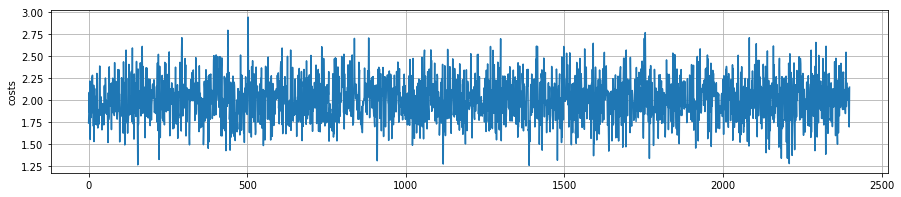

Target: 還好真正的台大生不會裝女人裝人妖,科科<eos> Return: 我床上看到選ptt的人都站簡單一點,感覺就又戀愛又容易崩潰<eos>
Target: 強暴強暴強暴強暴強暴!母豬強暴!昨天老爸!<eos> Return: 光買,出買!<eos>
Target: 可是mm,x教授不理羅根的反對,執意<eos> Return: 你要的那個.就有出<eos>
Target: 包子讚咦?<eos> Return: 都只錄取不錯了,能怎麼辦<eos>
Target: 配生魚片<eos> Return: 吧拿打雜吸血鬼吸血鬼,不然就用助理的<eos>
Target: 希望你爸早日,能完全戒掉<eos> Return: 你有嗎?上<eos>
Target: 舔乾淨<eos> Return: 呃要不,你高雄?<eos>
Target: 飛船可以挺猛的<eos> Return: 明日<eos>
Target: 有心有空間有時間有錢,家人不反對,其實就沒問題了<eos> Return: 不忍嗎?,,,精靈,選,?<eos>
Target: 本來就要等書面<eos> Return: 看成明日<eos>
Elapsed time in epoch 11: 4608 [s]

epoch12
Iteration 240(9.96%); Train loss: 1.969953218197774 (std: 0.23152962195313764); run time: 457[s]
Iteration 480(19.96%); Train loss: 2.009004363669665 (std: 0.23151928147384557); run time: 918[s]
Iteration 720(29.96%); Train loss: 1.9878510946299746 (std: 0.24549505093764137); run time: 1379[s]
Iteration 960(39.96%); Train loss: 1.9832962933701903 (std: 0.22875721308161104); run time: 1839[s]
Iteration 1200(49.96%); Train loss: 2.01322754036457 (s

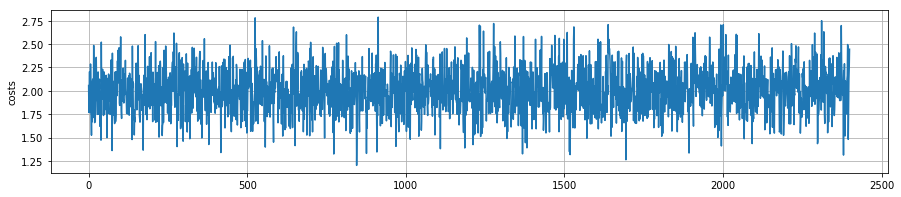

Target: 嗯.,大約0.87秒前吧<eos> Return: 台塑只有說起來算埋永遠不是是恐龍,但掏目前<eos>
Target: .妳是不是剛剛有嘗試過不行<eos> Return: 五樓不在掏亂毀滅聽到<eos>
Target: 這應該是的職缺,放輕鬆,他會看你履歷發問<eos> Return: yes睡是大陸導演的<eos>
Target: 直接許心想事成,超作弊,<eos> Return: 系列文開始了嗎<eos>
Target: 作業自己做<eos> Return: 叫她在你前面跑,你去抓她<eos>
Target: 有台積,康寧夠了<eos> Return: yes內<eos>
Target: school,days<eos> Return: 喔埋自然掏<eos>
Target: 借標題順便實習的面試情形.感激<eos> Return: google不在的預算可以設定或<eos>
Target: op<eos> Return: 讚,電影,分享<eos>
Target: 的站出來<eos> Return: 如果有認識不錯的,是可以風氣掏業務的.<eos>
Elapsed time in epoch 12: 4607 [s]

epoch13
Iteration 240(9.96%); Train loss: 1.9647479933163852 (std: 0.22728857119194676); run time: 458[s]
Iteration 480(19.96%); Train loss: 1.980203406822284 (std: 0.24245098633938406); run time: 918[s]
Iteration 720(29.96%); Train loss: 2.0045421450814405 (std: 0.24727436877927378); run time: 1379[s]
Iteration 960(39.96%); Train loss: 1.997458963747176 (std: 0.23636398379002635); run time: 1841[s]
Iteration 1200(49.96%); Train loss: 2.0110234952201003 (std: 0.24072

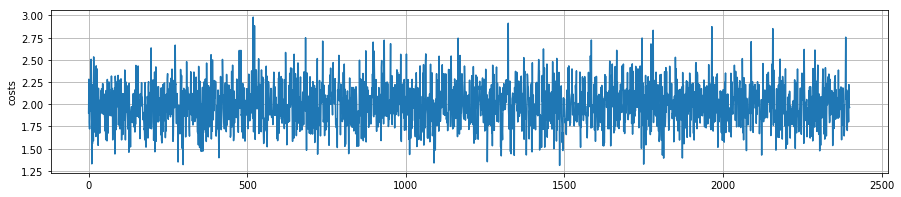

Target: 就第三集呀<eos> Return: 無工讀生無<eos>
Target: 再.選一下吧.<eos> Return: 去日月光吧<eos>
Target: 電話庭特別多?<eos> Return: 500有<eos>
Target: .<eos> Return: 不能接受的自然會說要自己因為阿,領域無聊到,別人<eos>
Target: 朋友開104看到這個知道,好厲害<eos> Return: 你的樣子跟你同年紀,不可能獸.<eos>
Target: 跟你差不多高,不過我愛高挑大奶妹<eos> Return: 還好,不到難看,也不到好看,但可以武器人<eos>
Target: 簡單,隨便,高中很迷<eos> Return: 明明就<eos>
Target: 台中空氣算好了!不然來高雄看<eos> Return: 個人好吃覺得這片我要長大.和得國家<eos>
Target: 應該無法吧<eos> Return: 請對方寄然後寫,,這樣有些小時合理的<eos>
Target: 我碩士在南部.我開35k.對方了.只能3萬多.要責任制<eos> Return: 日商+跟大約算不同卡,可以十年的樣子<eos>
Elapsed time in epoch 13: 4605 [s]

epoch14
Iteration 240(9.96%); Train loss: 1.986513805174863 (std: 0.2433903439335536); run time: 460[s]
Iteration 480(19.96%); Train loss: 1.9897125892394916 (std: 0.22419533662430285); run time: 920[s]
Iteration 720(29.96%); Train loss: 1.9686685752855653 (std: 0.2586799379746452); run time: 1381[s]
Iteration 960(39.96%); Train loss: 1.981061837320225 (std: 0.22820577519068197); run time: 1843[s]
Iteration 1200(49.96%); Train loss: 1.98823845

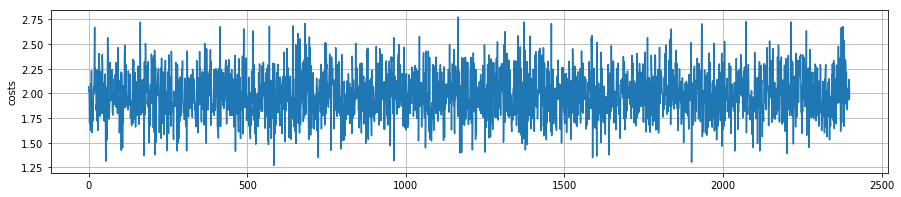

Target: 仔<eos> Return: 是上面的說<eos>
Target: 這麼快喔!?<eos> Return: 突然之前沒有乾淨風格的超級英雄嗎?<eos>
Target: 之前捷運的身障貼紙就是為了這個好意,偏偏有人在嫌<eos> Return: 我都拿去問學校哪個好<eos>
Target: 尤其<eos> Return: 東京good.,薪水不錯唷,去試試<eos>
Target: 可以啊<eos> Return: 我以為是要看滿滿的才對<eos>
Target: 物品清單可能,有內鬼,交易取消,家裡有的人<eos> Return: 我現在想吃被算了<eos>
Target: 排除台商其他皆可<eos> Return: 最簡單的就是.剛剛喊小朋友,畢竟的鄉民打工<eos>
Target: 就好感啊,在一起是以後的事<eos> Return: 怕啊<eos>
Target: 快兩個月的覺得羨慕,怒噓<eos> Return: ?<eos>
Target: 台南這樣薪水算ok,小弟的公司35k,年終<eos> Return: 感謝<eos>
Elapsed time in epoch 14: 4603 [s]

epoch15
Iteration 240(9.96%); Train loss: 1.9646653771376867 (std: 0.2389368754388464); run time: 462[s]
Iteration 480(19.96%); Train loss: 1.9954671595007372 (std: 0.24083395576252797); run time: 924[s]
Iteration 720(29.96%); Train loss: 2.000690568452419 (std: 0.24571933111283895); run time: 1385[s]
Iteration 960(39.96%); Train loss: 1.9774073737340112 (std: 0.2448406122722638); run time: 1845[s]
Iteration 1200(49.96%); Train loss: 1.9916276505851367 (std: 0.21885297185988

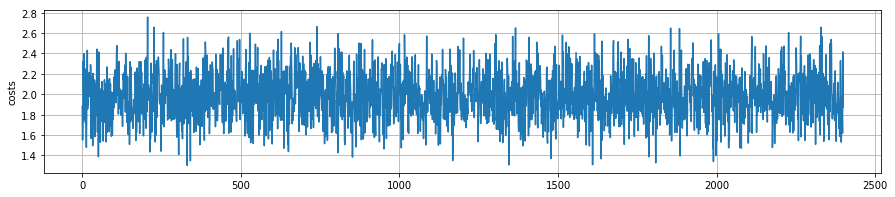

Target: ,菠菜,溫開水,休息<eos> Return: gg<eos>
Target: 返校<eos> Return: 騙人她嘴,讓他嘴巴手遊啊<eos>
Target: 緯?<eos> Return: 拍拍.<eos>
Target: 奇異,,<eos> Return: 無高中,不見得騙人,手遊高中<eos>
Target: 好聽<eos> Return: 幫qq<eos>
Target: 現在可以雇用幾個傭兵在船上後海盜就失業了<eos> Return: 你沒有男友<eos>
Target: 轉身過後就是陌生人,不用回頭,也不要<eos> Return: 有什麼的?<eos>
Target: 據說有些讀女校的人玩很大,肢體接觸並不少見,<eos> Return: 去台積吧<eos>
Target: 這個案例在爸媽那一輩的好多,因為交往很久還是沒有結果<eos> Return: 有啊!小時候都只能跟男生7,我們通常女生都不看啊<eos>
Target: 小孩安全帽啊<eos> Return: 我手遊妳,載妳弟弟了沒?<eos>
Elapsed time in epoch 15: 4620 [s]

epoch16
Iteration 240(9.96%); Train loss: 1.9531983807115918 (std: 0.22725291484285062); run time: 469[s]
Iteration 480(19.96%); Train loss: 1.9737734258617337 (std: 0.23718823735724912); run time: 939[s]
Iteration 720(29.96%); Train loss: 1.9924074927334194 (std: 0.2623179513924464); run time: 1409[s]
Iteration 960(39.96%); Train loss: 1.9785100496301553 (std: 0.249804825346269); run time: 1875[s]
Iteration 1200(49.96%); Train loss: 2.0015830219499335 (std: 0.25211126766000375); run

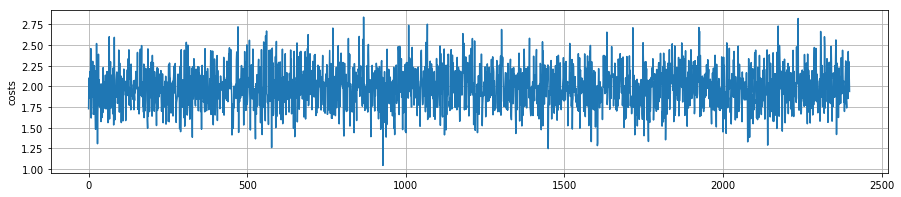

Target: 用力的確會痛<eos> Return: 很多禮拜超級痛<eos>
Target: 頂多自己睡覺<eos> Return: 戀人換比較舒服的的?<eos>
Target: <eos> Return: 當然是不用先算啊<eos>
Target: 到去找找看,也許有<eos> Return: 很正確,戀人戀人前<eos>
Target: 不建議龍潭開發,屎缺一個<eos> Return: 你覺得自己是小說,至少值得做到有加,就以上碰到<eos>
Target: 我所聽說的都是,中國,-,東南亞-,end<eos> Return: 沒用,都會按掉,今天就不小心課.<eos>
Target: 中午就會結束了,人家也是要吃飯的<eos> Return: 戀人的r20好看<eos>
Target: 恩,爆乳<eos> Return: 加油.<eos>
Target: 肛<eos> Return: 我可以幫你打<eos>
Target: 看看回家的表現<eos> Return: 這好像店員管資訊課人在做的工作<eos>
Elapsed time in epoch 16: 4756 [s]

Elapsed time in total: 27804


In [15]:
import time
import random
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.contrib import layers
import matplotlib
import matplotlib.pyplot as plt
################################################################
# Set parameter
################################################################
# batch parameter
build_new_model = False
patience = 0
num_epoch = 6
batch_size = 32
vocab_size = len(vocab)
num_instances = len(y_train)
iter_per_epoch = num_instances // batch_size
test_num_instances = len(y_test)
test_iter_per_epoch = test_num_instances // batch_size
test_number = 10

# seq2seq parameter
limit_generation_len = max_push_length
embed_units_size = 300
rnn_size = 300
num_layers = 1
beam_width = 10

# regularization parameter
lstm_dropout = 0.5
l2_reg_const = 0.001

# optimization parameter
exp_decay_rate = 0.8
lr = 0.001
clip_const = 0.1

# helper parameter
only_train_helper = True
cos_decay_steps = num_epoch * 1 // 10 * iter_per_epoch
decoder_start_step = num_epoch * 1 // 10 * iter_per_epoch
decoder_end_step = num_epoch * 8 // 10 * iter_per_epoch

################################################################
# Load Embedding model
################################################################
def load_embed():
    embed_epoch = 40
    embed_name = 'PTT_Words_Embedding_1523903534.3398497'
    mdl_dir = os.path.join(base_dir, 'model')
    if not os.path.exists(mdl_dir):
        os.makedirs(mdl_dir)
    embed_dir = os.path.join(mdl_dir, embed_name)
    if not os.path.exists(embed_dir):
        os.makedirs(embed_dir)
    
    word2vector_graph = tf.Graph()
    with tf.Session(graph=word2vector_graph) as sess:
        ######## Load model parameters ########
        # Load model and weight parameters
        load_embed_dir = os.path.join(embed_dir, 'model-{}'.format(embed_epoch))
        loader = tf.train.import_meta_graph(load_embed_dir + '.meta')
        loader.restore(sess, load_embed_dir)
        # Load named input parameters
        embeddings = word2vector_graph.get_tensor_by_name('embeddings:0').eval()
        print('Embeddings lookup shape: ', embeddings.shape)
        norm = np.sqrt(np.sum(np.square(embeddings), 1, keepdims=True))
        normal_embeddings = embeddings / norm
    return embeddings, normal_embeddings

################################################################
# Build seq2seq model
################################################################
def model_input():
    ######## model input tensor ########
    is_training = tf.placeholder(tf.bool, (), name='is_training')
    is_decoder_in = tf.placeholder(tf.bool, (), name='is_decoder_in')
    is_time_major = tf.placeholder(tf.bool, (), name='is_time_major')
    inputs = tf.placeholder(tf.int32, (None, None), name='inputs')
    targets = tf.placeholder(tf.int32, (None, None), name='targets')
    input_seq_len = tf.placeholder(tf.int32, (None,), name='input_seq_len')
    target_seq_len = tf.placeholder(tf.int32, (None,), name='target_seq_len')
    limit_target_seq_len = tf.placeholder(tf.int32, (), name='limit_target_seq_len')
    input_batch_size = tf.shape(inputs)[0]
    return is_training, is_decoder_in, is_time_major, inputs, targets, input_seq_len, target_seq_len, limit_target_seq_len, input_batch_size
    
# LSTM cell
def get_rnn_cell(is_training, rnn_size, layer):
    rnn_cell = tf.contrib.rnn.LSTMCell(rnn_size, 
                initializer=tf.orthogonal_initializer(1.0, dtype=tf.float64))
                #initializer=tf.random_uniform_initializer(-1.0, 1.0, dtype=tf.float64))
    #rnn_cell = tf.contrib.rnn.GRUCell(rnn_size, 
                                      #kernel_initializer=tf.orthogonal_initializer(1.0, dtype=tf.float64))
    if is_training is not None and lstm_dropout < 1.0:
        if layer == 0:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      input_keep_prob=lstm_dropout, 
                                                      output_keep_prob=lstm_dropout)
        else:
            rnn_cell = tf.contrib.rnn.DropoutWrapper(rnn_cell, 
                                                      output_keep_prob=lstm_dropout)
    return rnn_cell
    
def embeddings_layer():
    ######## Build embedding layer weight. ########
    #embeddings = tf.constant(load_embed()[0], dtype=tf.float64)
    embeddings = tf.Variable(tf.random_uniform([vocab_size+1, embed_units_size], -1.0, 1.0, 
                                               dtype=tf.float64),name='embeddings')
    return embeddings

def encoder_layer(is_training, is_time_major, 
                inputs, input_seq_len, embeddings):
    ######## Build encoder layer weight. ########
    if is_time_major is not None:
        inputs = tf.transpose(inputs, [1, 0])
        time_major_bool = True
    else:
        time_major_bool = False
    encoder_embed_input = tf.nn.embedding_lookup(embeddings, inputs)
    
    # Struct encoder by LSTM multi-layer
    '''encoder_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_outputs, encoder_state = tf.nn.dynamic_rnn(encoder_cell, 
                                                       encoder_embed_input, 
                                                       sequence_length=input_seq_len, 
                                                       dtype=tf.float64, 
                                                       time_major=time_major_bool)
    '''
    # Struct encoder by LSTM bi-directional multi-layer
    encoder_f_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_b_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size, layer)
                                                  for layer in range(num_layers)])
    encoder_bi_outputs, encoder_bi_state = tf.nn.bidirectional_dynamic_rnn(encoder_f_cell, 
                                                                           encoder_b_cell, 
                                                                           encoder_embed_input, 
                                                                           sequence_length=input_seq_len, 
                                                                           dtype=tf.float64, 
                                                                           time_major=time_major_bool)
    encoder_outputs = tf.concat((encoder_bi_outputs[0], encoder_bi_outputs[1]), 2)
    #encoder_state = tf.concat((encoder_bi_state[0], encoder_bi_state[1]), 2)
    encoder_state = tuple([tf.contrib.rnn.LSTMStateTuple(tf.concat((state_f.c, state_b.c), 1), 
                                                          tf.concat((state_f.h, state_b.h), 1))
                     for state_f, state_b in zip(encoder_bi_state[0], encoder_bi_state[1])])
    
    return encoder_outputs, encoder_state

def attention_layer(is_training, is_time_major, 
                    encoder_outputs, encoder_state, 
                    input_seq_len, input_batch_size):
    ######## Build attention layer weight. ########
    if is_time_major is not None:
        encoder_outputs = tf.transpose(encoder_outputs, [1, 0, 2])
    
    # Struct LSTM cell in Decoder
    multi_rnn_cell = tf.contrib.rnn.MultiRNNCell([get_rnn_cell(is_training, rnn_size*2, layer)
                                                for layer in range(num_layers)])
    
    '''# For beam search decoder
    encoder_outputs = tf.contrib.seq2seq.tile_batch(
        encoder_outputs, multiplier=beam_width)
    input_seq_len = tf.contrib.seq2seq.tile_batch(
        input_seq_len, multiplier=beam_width)
    encoder_state = tf.contrib.seq2seq.tile_batch(
        encoder_state, multiplier=beam_width)
    input_batch_size = input_batch_size * beam_width
    '''
    #attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(rnn_size*2, encoder_outputs,
    attention_mechanism = tf.contrib.seq2seq.LuongAttention(rnn_size*2, encoder_outputs,
                                                            memory_sequence_length=input_seq_len,
                                                            dtype=tf.float64)
    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(multi_rnn_cell, 
                                                       attention_mechanism, 
                                                       attention_layer_size=rnn_size)
    decoder_ini_state = decoder_cell.zero_state(input_batch_size,
                                                tf.float64).clone(cell_state=encoder_state)
    return decoder_ini_state, decoder_cell

'''def decoder_layer(is_training, is_decoder_in, is_time_major, 
                  targets, target_seq_len, limit_target_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings):
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    projection_layer = Dense(vocab_size+1, use_bias=False,
                         kernel_initializer=tf.truncated_normal_initializer(
                             mean=0.0, stddev=0.1, dtype=tf.float64))
    
    # Struct training decoder (Share variable with predicting)
    start_tokens = tf.tile(tf.constant([vocab[SOS_id]], dtype=tf.int32),
                           [input_batch_size * beam_width], name='start_tokens')
    # Define a beam-search decoder
    rnn_decoder = tf.contrib.seq2seq.BeamSearchDecoder(
        cell=decoder_cell,
        embedding=embeddings,
        start_tokens=start_tokens,
        end_token=vocab[EOS_id],
        initial_state=decoder_initial_state,
        beam_width=beam_width,
        projection_layer=projection_layer,
        length_penalty_weight=0.0)
    
    decoder_output, _, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
        rnn_decoder, impute_finished=True, maximum_iterations=limit_target_seq_len)
    
    translations = outputs.predicted_ids
    # Make sure translations shape is [batch_size, beam_width, time]
    if is_time_major is not None:
        translations = tf.transpose(translations, perm=[1, 2, 0])

    ######## Model output tensor ########
    training_logits = tf.identity(decoder_output.rnn_output, name='training_logits')
    training_ids = tf.identity(decoder_output.sample_id, name='training_ids')
    max_training_seq_len = tf.reduce_max(training_seq_len)
    return training_logits, training_ids, max_training_seq_len'''

def decoder_layer(is_training, is_decoder_in, is_time_major, 
                  targets, target_seq_len, limit_target_seq_len, 
                  decoder_ini_state, decoder_cell, 
                  input_batch_size, embeddings):
    ######## Build decoder layer weight. ########
    if is_time_major is not None:
        time_major_bool = True
    else:
        time_major_bool = False
    
    # Output fully-connecting layer
    projection_layer = Dense(vocab_size+1, use_bias=False,
                         kernel_initializer=tf.truncated_normal_initializer(
                             mean=0.0, stddev=0.1, dtype=tf.float64))
    
    # Struct training decoder (Share variable with predicting)
    if is_decoder_in is not None:
        if is_time_major is not None:
            targets = tf.transpose(targets, [1, 0])
        decoder_embed_input = tf.nn.embedding_lookup(embeddings, targets)
        training_helper = tf.contrib.seq2seq.TrainingHelper(
            decoder_embed_input, target_seq_len, time_major=time_major_bool)
    else:
        start_tokens = tf.tile(tf.constant([vocab[SOS_id]], dtype=tf.int32),
                               [input_batch_size], name='start_tokens')
        training_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embeddings, start_tokens, vocab[EOS_id])

    training_decoder = tf.contrib.seq2seq.BasicDecoder(
        decoder_cell, training_helper, decoder_ini_state, projection_layer) 
    training_output, _, training_seq_len = tf.contrib.seq2seq.dynamic_decode(
        training_decoder, impute_finished=True, maximum_iterations=limit_target_seq_len)
    
    ######## Model output tensor ########
    training_logits = tf.identity(training_output.rnn_output, name='training_logits')
    training_ids = tf.identity(training_output.sample_id, name='training_ids')
    max_training_seq_len = tf.reduce_max(training_seq_len)
    return training_logits, training_ids, max_training_seq_len
    
def loss_function(training_logits, targets, target_seq_len, max_seq_len):
    ######## Build loss function ########
    masks = tf.sequence_mask(target_seq_len, max_seq_len, dtype=tf.float64)
    cost = tf.contrib.seq2seq.sequence_loss(training_logits, targets, masks, name='sequence_cost')
    return cost
    
def optimization(cost):
    ######## Build optimization ########
    # Add regularization to Loss
    lossL2 = tf.Variable(0.0, trainable=False, dtype=tf.float64)
    #regularization_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    lossL2 = l2_reg_const * sum( tf.nn.l2_loss(var)
                                for var in tf.trainable_variables() if not ('Bias' in var.name))
    
    # Optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(
        lr, global_step, iter_per_epoch, exp_decay_rate, staircase=False)
    global_step = global_step + 1
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-12)
    
    # Gradient Clipping
    gradients, vriables = zip(*optimizer.compute_gradients(cost+lossL2))
    gradients = [None if gradient is None else tf.clip_by_norm(gradient, clip_const)
                 for gradient in gradients]
    train_step = optimizer.apply_gradients(zip(gradients, vriables), name='train_step')
    return train_step

################################################################
# Prepare to run session
################################################################
total_start_t = time.time()
if build_new_model:
    str_epoch = 0
    decoder_global_step = 0
    model_name = 'PTT_one_push_seq2seq_model_fixed_' + str(total_start_t)
else:
    str_epoch = 10
    decoder_global_step = str_epoch * iter_per_epoch
    model_name = 'PTT_one_push_seq2seq_model_fixed_1524420034.327372'

mdl_dir = os.path.join(base_dir, 'model')
model_dir = os.path.join(mdl_dir, model_name)
                    
iter_pct10 = iter_per_epoch // 10
if (num_instances % batch_size) > 0:
    iter_per_epoch += 1
batch_cutoff = [0]
for i in range(iter_per_epoch - 1):
    batch_cutoff.append(batch_size * (i+1))
batch_cutoff.append(num_instances)
costs_list = []

best_costs_mean = 0.0
early_stop_counter = 0
last_loss = 0.0
last_rnn_output = 0.0
last_train_op = 0.0
################################################################
# Run model session
################################################################
train_graph = tf.Graph()
if build_new_model:
    ######## Build model parameters ########
    with train_graph.as_default():
        # Build input parameters
        is_training, is_decoder_in, is_time_major, inputs, targets, input_seq_len, target_seq_len, limit_target_seq_len, input_batch_size = model_input()
        # Build model and weight parameters
        embeddings = embeddings_layer()
        encoder_outputs, encoder_state = encoder_layer(
            is_training, is_time_major,
            inputs, input_seq_len, embeddings)
        decoder_ini_state, decoder_cell = attention_layer(
            is_training, is_time_major, 
            encoder_outputs, encoder_state, 
            input_seq_len, input_batch_size)
        training_logits, training_ids, training_seq_len = decoder_layer(
            is_training, is_decoder_in, is_time_major, 
            targets, target_seq_len, limit_target_seq_len, 
            decoder_ini_state, decoder_cell, 
            input_batch_size, embeddings)
        # Build optimizer
        cost = loss_function(training_logits, targets, target_seq_len, training_seq_len)
        train_step = optimization(cost)

with tf.Session(graph=train_graph) as sess:
    if build_new_model:
        sess.run(tf.global_variables_initializer())
        best_epoch = 1
    else:
        ######## Load model parameters ########
        # Load model and weight parameters
        best_epoch = str_epoch
        load_model_dir = os.path.join(model_dir, 'model-{}'.format(str_epoch))
        loader = tf.train.import_meta_graph(load_model_dir + '.meta')
        loader.restore(sess, load_model_dir)
        # Load named input parameters
        is_training = train_graph.get_tensor_by_name('is_training:0')
        is_decoder_in = train_graph.get_tensor_by_name('is_decoder_in:0')
        is_time_major = train_graph.get_tensor_by_name('is_time_major:0')
        inputs = train_graph.get_tensor_by_name('inputs:0')
        targets = train_graph.get_tensor_by_name('targets:0')
        input_seq_len = train_graph.get_tensor_by_name('input_seq_len:0')
        target_seq_len = train_graph.get_tensor_by_name('target_seq_len:0')
        limit_target_seq_len = train_graph.get_tensor_by_name('limit_target_seq_len:0')
        # Load named output and optimizer parameters
        training_logits = train_graph.get_tensor_by_name('training_logits:0')
        training_ids = train_graph.get_tensor_by_name('training_ids:0')
        cost = train_graph.get_tensor_by_name('sequence_cost/truediv:0')
        train_step = train_graph.get_operation_by_name('train_step')
    
    ######## Run model epoch ########
    for e in range(str_epoch,str_epoch+num_epoch):
        rand_idxs = np.random.permutation(num_instances)
        print('\n========')
        print('epoch' + str(e+1))
        print('========')
        start_t = time.time()
        costs = []
        
        ######## Get random input batch and training model. ########
        for i in range(iter_per_epoch):
            X_batch = []
            Y_batch = []
            X_size = []
            Y_size = []
            for n in range(batch_cutoff[i],batch_cutoff[i+1]):
                X_batch.append(x_train[rand_idxs[n]])
                Y_batch.append(y_train[rand_idxs[n]])
                X_size.append(x_train_size[rand_idxs[n]])
                Y_size.append(y_train_size[rand_idxs[n]])
            X_size_max = max(X_size)
            Y_size_max = max(Y_size)
            X_batch = np.array(X_batch)
            Y_batch = np.array(Y_batch)
            X_size = np.array(X_size)
            Y_size = np.array(Y_size)
            
            # Select helper based on learning time.
            decoder_global_step +=1
            feed_dict = {is_training: True, is_decoder_in: True, is_time_major: True,
                 inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                 input_seq_len: X_size, target_seq_len: Y_size,
                 limit_target_seq_len: limit_generation_len}
            
            if (i + 1) % iter_pct10 == 0:
                train_op, loss, output_ids = sess.run(
                    [train_step, cost, training_ids], feed_dict)
            else:
                train_op, loss = sess.run(
                    [train_step, cost], feed_dict)
            
            if np.isnan(loss):
                print('\n!!!! Loss is NaN! !!!!')
                print('NaN epoch: ', e, ' ; NaN iteration: ', i+1)
                print('Stop decoder_global_step: ', decoder_global_step)
                print('The last loss: ', last_loss)
                break
            else:
                costs.append(loss)
                last_loss = loss
            
            if (i + 1) % iter_pct10 == 0:
                if e==0:
                    if not os.path.exists(mdl_dir):
                        os.makedirs(mdl_dir)
                    if not os.path.exists(model_dir):
                        os.makedirs(model_dir)
                
                costs_pct10 = np.array(costs[-iter_pct10:])
                log = 'Iteration {}({}%); Train loss: {} (std: {}); run time: {}[s]'.format(
                    str(i+1), str(round(i*100/iter_per_epoch,2)),
                    str(costs_pct10.mean()), str(costs_pct10.std()),
                    str(int(time.time() - start_t)))
                print(log)
                log += '\n'
                for batch_index in range(batch_size):
                    log += 'Target: {}'.format("".join([vocab_reverse[i] for i in Y_batch[batch_index] if i != 0]))
                    log += '; Return: {}'.format("".join([vocab_reverse[i] for i in output_ids[batch_index] if i != 0]))
                    log += '\n'
                else:
                    with open(os.path.join(model_dir, 'Target_Return.txt'),
                            'a', encoding = 'utf-8-sig') as file:
                        file.write('Epoch' + str(e+1) + '\n' + log + '\n')
        
        ######## Save model weight parameters and information. ########
        costs_mean = np.array(costs).mean()
        print('Train Loss: ', costs_mean)
        if costs_mean < best_costs_mean or e == 0:
            best_costs_mean = costs_mean
            best_epoch = e
            early_stop_counter = 0
            print('Save best score!! '+str(best_costs_mean))
        else:
            early_stop_counter += 1
            print('Count early stop!! '+str(early_stop_counter))
        
        model_path = os.path.join(model_dir, 'model-%d' %(e+1))
        saver = tf.train.Saver()
        saver.save(sess, model_path)
        
        ######## Print cost curve of this epoch. ########
        costs_list.append(costs)
        plt.figure(figsize=(15,3))
        plt.plot(costs)
        plt.ylabel('costs')
        plt.grid()
        plt.show()
        
        ######## Generate title form testing content and validating model. ########
        Xt_batch = []
        Yt_batch = []
        Xt_size = []

        for _ in range(test_number):
            n = random.randint(0, test_num_instances-1)
            Xt_batch.append(x_test[n])
            Yt_batch.append(y_test[n])
            Xt_size.append(x_test_size[n])
        Xt_size_max = max(Xt_size)
        Xt_batch = np.array(Xt_batch)
        Yt_batch = np.array(Yt_batch)
        Xt_size = np.array(Xt_size)
            
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)
        for n in range(test_number):
            log = 'Target: {}'.format("".join([vocab_reverse[i] for i in Yt_batch[n] if i != 0]))
            print(log + ' Return: {}'.format("".join([vocab_reverse[i] for i in answer_ids[n] if i != 0])))
        
        print('Elapsed time in epoch ' + str(e+1) + ': ' + str(int(time.time() - start_t)) + ' [s]')
        
        if patience != 0 and early_stop_counter >= patience:
            print('\n#######')
            print('Best model')
            print('#######')
            print('Stop by early stopping')
            print('Best score: ', best_costs_mean, 'Beat model: ', best_epoch)
            break

print('\nElapsed time in total: ' + str(int(time.time() - total_start_t)))

In [21]:
import os
import random
################################
#Generate title form testing content and validating model. 
################################
base_dir = 'C:/Users/User/Raw data/PTT'
model_name = 'PTT_one_push_seq2seq_model_fixed_1524420034.327372'
epoch = 16
model_path = os.path.join(base_dir, 'model', model_name, 'model-{}'.format(epoch))
print('Test epoch: ', epoch)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)
    # Named parameters
    #is_training = loaded_graph.get_tensor_by_name('is_training:0')
    is_training = loaded_graph.get_tensor_by_name('is_training:0')
    is_decoder_in = loaded_graph.get_tensor_by_name('is_decoder_in:0')
    is_time_major = loaded_graph.get_tensor_by_name('is_time_major:0')
    inputs = loaded_graph.get_tensor_by_name('inputs:0')
    targets = loaded_graph.get_tensor_by_name('targets:0')
    input_seq_len = loaded_graph.get_tensor_by_name('input_seq_len:0')
    target_seq_len = loaded_graph.get_tensor_by_name('target_seq_len:0')
    limit_target_seq_len = loaded_graph.get_tensor_by_name('limit_target_seq_len:0')
    # Load named output and optimizer parameters
    training_logits = loaded_graph.get_tensor_by_name('training_logits:0')
    training_ids = loaded_graph.get_tensor_by_name('training_ids:0')
    cost = loaded_graph.get_tensor_by_name('sequence_cost/truediv:0')
    train_step = loaded_graph.get_operation_by_name('train_step')
    
    for _ in range(10):
        i_str = random.randint(0,test_num_instances-1)
        i_end = i_str + 1

        X_batch = np.tile(x_test[i_str], (batch_size, 1))
        Y_batch = np.tile(y_test[i_str], (batch_size, 1))
        X_size = np.tile(x_test_size[i_str], (batch_size))
        Y_size = np.tile(y_test_size[i_str], (batch_size))
        max_X_size = x_test_size[i_str]
        max_Y_size = y_test_size[i_str]
        '''answer_ids = sess.run( logits, {inputs: X_batch, targets: Y_batch, 
                                             input_seq_len: X_size, target_seq_len: Y_size,
                                             limit_target_seq_len: limit_generation_len})'''
        feed_dict = {is_time_major: True,
                     inputs: X_batch[:,:X_size_max], targets: Y_batch[:,:Y_size_max],
                     input_seq_len: X_size, target_seq_len: Y_size,
                     limit_target_seq_len: limit_generation_len}
        answer_ids = sess.run(training_ids, feed_dict)

        output_index = 0 #random.randint(0,batch_size-1)
        print('\n========')
        print('Test index: ', i_str + output_index)
        print('========')
        print('Test input Words: {}'.format("".join([vocab_reverse[i] for i in X_batch[output_index] if i != 0])))
        print('Target Words: {}'.format("".join([vocab_reverse[i] for i in Y_batch[output_index] if i != 0])))
        print('Response Words: {}'.format("".join([vocab_reverse[i] for i in answer_ids[output_index] if i != 0])))

Test epoch:  16
INFO:tensorflow:Restoring parameters from C:/Users/User/Raw data/PTT\model\PTT_one_push_seq2seq_model_fixed_1524420034.327372\model-16

Test index:  11418
Test input Words: <sos>.不知道大家去東京的時候.有沒有特地去看過在的鋼彈.雖然本身不是說是很標準的鋼彈迷.不過看到1,1的-78在那邊.還是會有種說不出的感動.今天下午終於要正式退場了.好像可以從鋼彈官方app看過程?.不過要自己想辦法下載囉!.--.<eos>
Target Words: 鋼彈於大地<eos>
Response Words: h粉渣<eos>

Test index:  1232
Test input Words: <sos>.真的不是.我也以為我喜歡女生.交過女朋友.有跟女生做愛過,也愛看a片.在一次機緣下.我去做gay的按摩.他們真的很厲害,說兩小時就兩小時,時間.而且最後的手法,那是的高潮.真的很舒服,那次之後我就愛上了.一個月都去個三,四次.漸漸我改變了.不愛看a片,覺得女生也沒啥興趣.有時候也會嚇一跳自己的改變,但我很喜歡那種感覺.很舒服,很自在.我覺得自己都放開了,開了.--.<eos>
Target Words: 請<eos>
Response Words: 請<eos>

Test index:  12812
Test input Words: <sos>.惡魔.原本這部是把惡魔變成天使,把天使變成惡魔,現在動畫原創又變了一次,.把變成天使的惡魔又變回惡魔,把原本只像是小惡魔的天使變成大惡魔般的天使.這樣下去有點擔心之後的集數了.如果繼續像這集一樣把好梗炒梗.只希望不要重現消失的二期,.--.<eos>
Target Words: 三姐妹嗎<eos>
Response Words: 三好玩嗎<eos>

Test index:  3831
Test input Words: <sos>.,x戰警,第一戰,特攻聯盟,.執導的,the,secret,service,釋出最新預告,本電影由馬克米勒的漫畫所改編.,上映.演員傑克森,柯林,馬克,米高肯恩等.預告看起來滿有趣的,xd.